# EM Algorithm

---


The expectation-maximization algorithm is an approach for performing 
maximum likelihood estimation in the presence of latent variables. It does this by first estimating the values for the latent variables, then optimizing the model, then repeating these two steps until convergence. It is an effective and general approach and is most commonly used for density estimation with missing data, such as clustering algorithms like the Gaussian Mixture Model.


---

Steps:

```
1.   Expectation Step: Using the observed available data of the dataset, estimate the values of the missing (latent variables).
2.   Maximization Step: Complete data generated after the E-Steps is used to update the parameters,θ by maximizing the likelihood function.
3.   Repeating 1 and 2 until they converge.

```



# Implementation

## Code

### Imports:

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import numpy as np 
from scipy import stats
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
import warnings
warnings.filterwarnings('ignore')

### Initialization:

In [81]:
random_seed=1
np.random.seed(random_seed)

Mean1 = 2.0  # mean of first normal probability distribution
Standard_dev1 = 4.0 #@param {type:"number"}
Mean2 = 9.0 # mean of second normal  probability distribution
Standard_dev2 = 2.0 #@param {type:"number"}

# generate random data from guassian mix
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

### Visualization of data:

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


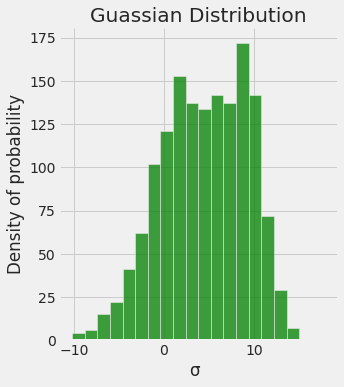

In [82]:
# For data visiualisation calculate left and right of the graph
plt.style.use('fivethirtyeight')
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))

ax = sns.displot(data, color='green', bins=20, kde=False)
ax.set(xlabel='σ ', ylabel='Density of probability',title="Guassian Distribution")
plt.show()

### Definitions and declarations:

Best single Gaussian: μ = 4.5, σ = 4.7


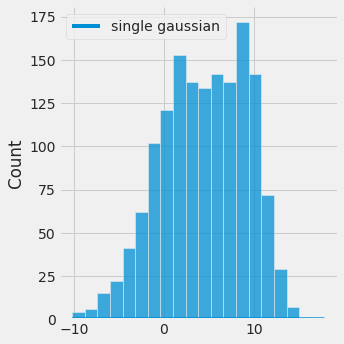

In [83]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.displot(data, bins=20, kde=False, kind='hist');
plt.plot(x, g_single, label='single gaussian');
plt.legend();

In [84]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one,self.two, self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one,self.two, self.mix)

 1 Mixture: Gaussian(8.38165, 2.26821), Gaussian(0.418187, 2.88611), mix=0.511)
 1 Mixture: Gaussian(8.31303, 2.44215), Gaussian(0.654713, 3.13239), mix=0.501)
 1 Mixture: Gaussian(8.28864, 2.50725), Gaussian(0.784423, 3.25617), mix=0.494)
 1 Mixture: Gaussian(8.28644, 2.53444), Gaussian(0.873627, 3.33155), mix=0.488)
 1 Mixture: Gaussian(8.29634, 2.54365), Gaussian(0.942257, 3.38261), mix=0.482)
 1 Mixture: Gaussian(8.31327, 2.54306), Gaussian(0.998966, 3.41994), mix=0.477)
 1 Mixture: Gaussian(8.33437, 2.53677), Gaussian(1.04822, 3.44895), mix=0.472)
 1 Mixture: Gaussian(8.35791, 2.52706), Gaussian(1.09255, 3.4727), mix=0.467)
 1 Mixture: Gaussian(8.38283, 2.5153), Gaussian(1.13348, 3.49302), mix=0.463)
 1 Mixture: Gaussian(8.40841, 2.50233), Gaussian(1.17197, 3.51107), mix=0.458)
 1 Mixture: Gaussian(8.43419, 2.48872), Gaussian(1.20863, 3.52757), mix=0.454)
 1 Mixture: Gaussian(8.45986, 2.47482), Gaussian(1.24387, 3.54299), mix=0.45)
 1 Mixture: Gaussian(8.48521, 2.46087), Gaussian(

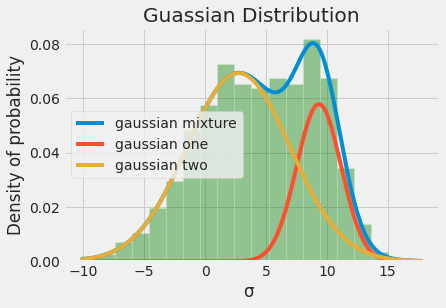

In [85]:
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass
      
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
ax = sns.distplot(data,color='green', bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
ax.set(xlabel='σ ', ylabel='Density of probability',title="Guassian Distribution")
plt.legend();

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 9.3, σ = 1.9, weight = 0.28
Gaussian 2: μ = 2.6, σ = 4.2, weight = 0.72


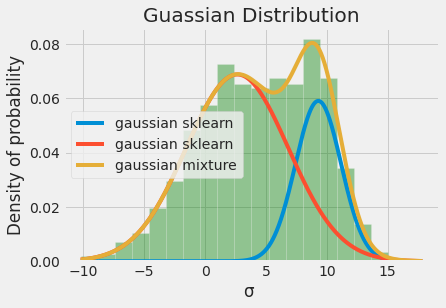

In [86]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2, tol=0.000001)
gmm.fit(np.expand_dims(data, 1)) # Parameters: array-like, shape (n_samples, n_features), 1 dimension dataset so 1 feature
Gaussian_nr = 1
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format(Gaussian_nr, mu, sd, p))
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1
ax = sns.distplot(data,color='green', bins=20, kde=False, norm_hist=True)
gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x]) #gmm gives log probability, hence the exp() function
plt.plot(x, gmm_sum, label='gaussian mixture');
ax.set(xlabel='σ ', ylabel='Density of probability',title="Guassian Distribution")
plt.legend();

## Estimation and Maximization Example

In [87]:
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix

In [88]:
df = px.data.iris()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
 5   species_id    150 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [89]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split as tts

In [90]:
X = df.iloc[:,0:4].values

In [91]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X)

In [92]:
gm.means_

array([[5.006     , 3.418     , 1.464     , 0.244     ],
       [6.54639415, 2.94946365, 5.48364578, 1.98726565],
       [5.9170732 , 2.77804839, 4.20540364, 1.29848217]])

In [93]:
def feature(x):
    species = ['setosa','versicolor','virginica']
    return species[x]

pred = gm.predict(X)
pred_features = list(map(feature,pred))

In [94]:
fig1 = px.scatter(df, x="sepal_width", y="sepal_length", color=pred_features,
                 size='petal_length', hover_data=['petal_width'])
fig1.show()

In [95]:
fig2 = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
                 size='petal_length', hover_data=['petal_width'])
fig2.show()

In [96]:
cm = confusion_matrix(df['species'], pred_features, labels=pred_features)
px.imshow(cm,text_auto=True,labels=dict(x="Predicted Label", y="True Label", color="No of classification"),
          x=pred_features,y=pred_features,title="Confusion Matrix",color_continuous_scale="aggrnyl")